In [ ]:
!pip install transformers

In [2]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing Google Colab stuff to mount drive where yelp data is saved 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


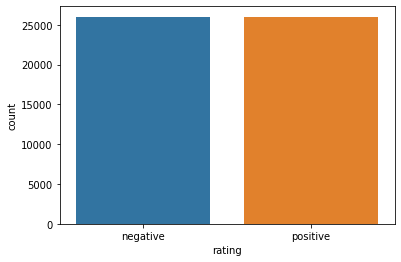

In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/My Drive/colab/final_dataset.csv")
sns.countplot(df.rating)


There is no imbalance in data that's good

In [4]:
df = df.sample(25000)
print("SHAPE::",df.shape)

SHAPE:: (25000, 3)


In [5]:
df.head()


,rating,review,split
1514,negative,i have decided that i hate this place . it was...,train
35076,positive,i would give the location stars and the resta...,train
27503,positive,"seriously , i have a new found love for colomb...",train
44908,positive,this could be my new favorite place to grab a ...,train
30926,positive,food was excellent . kind of in a crappy part ...,train


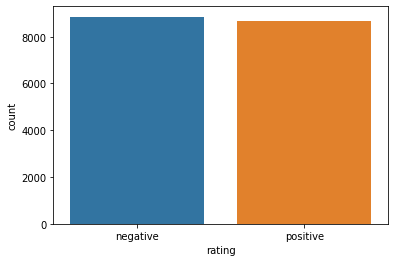

In [6]:
sns.countplot(df[df.split=='train'].rating)

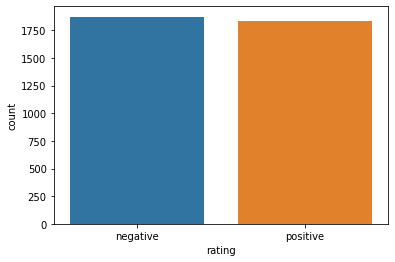

In [7]:
sns.countplot(df[df.split=='val'].rating)

Validation and Training data also has the same target distribution 

In [8]:
df.rating = df.rating.apply({'negative':0,'positive':1}.get)

In [9]:
df.head()

,rating,review,split
1514,0,i have decided that i hate this place . it was...,train
35076,1,i would give the location stars and the resta...,train
27503,1,"seriously , i have a new found love for colomb...",train
44908,1,this could be my new favorite place to grab a ...,train
30926,1,food was excellent . kind of in a crappy part ...,train


In [10]:
class_name = ['negative','positive']

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Setting device as per the availability

In [12]:
device

device(type='cuda', index=0)

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Loading pre-trained bert tokenizer 

100%|██████████| 25000/25000 [00:45<00:00, 550.50it/s]


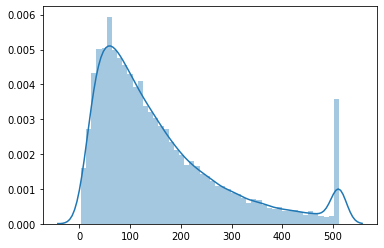

In [15]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.review):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)


as we can see the largest length of sentence is about 520 but that length is going out of memory so we will user smaller max_length

In [16]:
MAX_LEN = 120

In [17]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

Creating Pytorch dataset by converting the text into numerical vectors using the tokenizer 

In [18]:
df_train = df[df['split']=='train']
df_val = df[df['split']=='val']
df_test = df[df['split']=='test']

In [19]:
df_train.shape, df_val.shape, df_test.shape

((17511, 3), (3708, 3), (3781, 3))

In [20]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.rating.values),
                                                 df_train.rating.values)


In [21]:
class_weights

array([0.98898678, 1.01126126])

In [22]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.review.to_numpy(), 
        targets = df.rating.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

Creating Pytorch dataset loader 

In [23]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [40]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

Creating a fine-tuned bert model 

In [26]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [27]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

initializing optimizer and loss function for our model

In [28]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


function to train our model on each epoch

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

function to evaluate the model

In [30]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.2752137896366907 accuracy 0.8872708583176289
Val   loss 0.1945240000455544 accuracy 0.9274541531823084

Epoch 2/5
----------
Train loss 0.12353494769534994 accuracy 0.9597966992176346
Val   loss 0.24913227999711346 accuracy 0.924487594390507

Epoch 3/5
----------
Train loss 0.06052537221354466 accuracy 0.9845240134772428
Val   loss 0.32031279901074694 accuracy 0.9285329018338726

Epoch 4/5
----------
Train loss 0.03064419130761139 accuracy 0.9933184855233852
Val   loss 0.3762279807686292 accuracy 0.9279935275080905

Epoch 5/5
----------
Train loss 0.020794904315172877 accuracy 0.9956598709382674
Val   loss 0.3947189314098194 accuracy 0.9258360302049622



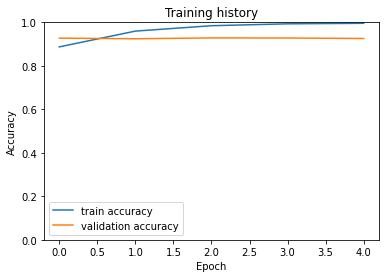

In [31]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [32]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.9206559111346205

In [33]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [35]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.91      0.94      0.92      1914
    positive       0.93      0.91      0.92      1867

    accuracy                           0.92      3781
   macro avg       0.92      0.92      0.92      3781
weighted avg       0.92      0.92      0.92      3781



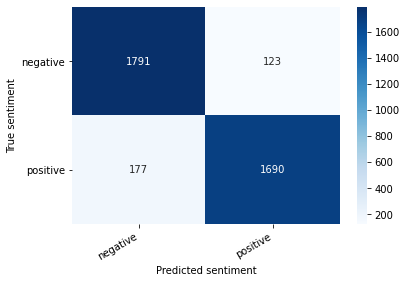

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [92]:
review_text = "the food was delicious but it was spicy"


In [93]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [94]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: the food was delicious but it was spicy
Sentiment  : positive


Model is working preety well 